# hw2: Решающие деревья

*Спасибо великому курсу великого Евгения Соколова*

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплементацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

Все данные, на которых будут обучаться модели, вы можете найти на диске.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw2-trees.ipynb``` и модуль с реализованными функциями и классами ```hw2code.py``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце <<hw2>> в строке со своей фамилией о том, что вы выполнили работу с указанием ника на Kaggle. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [2]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0, )
]

In [3]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

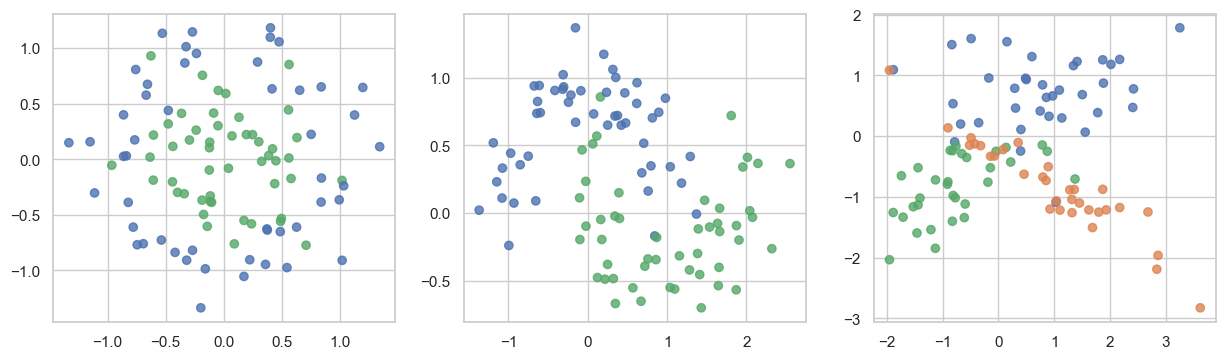

In [4]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [5]:
def plot_surface(clf, X, y, n_classes=3, plot_colors = "ryb", plot_step = 0.02):
    # Параметры графика
    plt.figure(figsize=(10, 10))
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    # Предсказания модели
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    plt.xlabel("feature 1")
    plt.ylabel("feature 2")
    plt.axis("tight")

    # Отображаем обучающие точки
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired, edgecolor='black', s=20)

    plt.title("Decision surface of a decision tree")
    plt.axis("tight")
    plt.show()

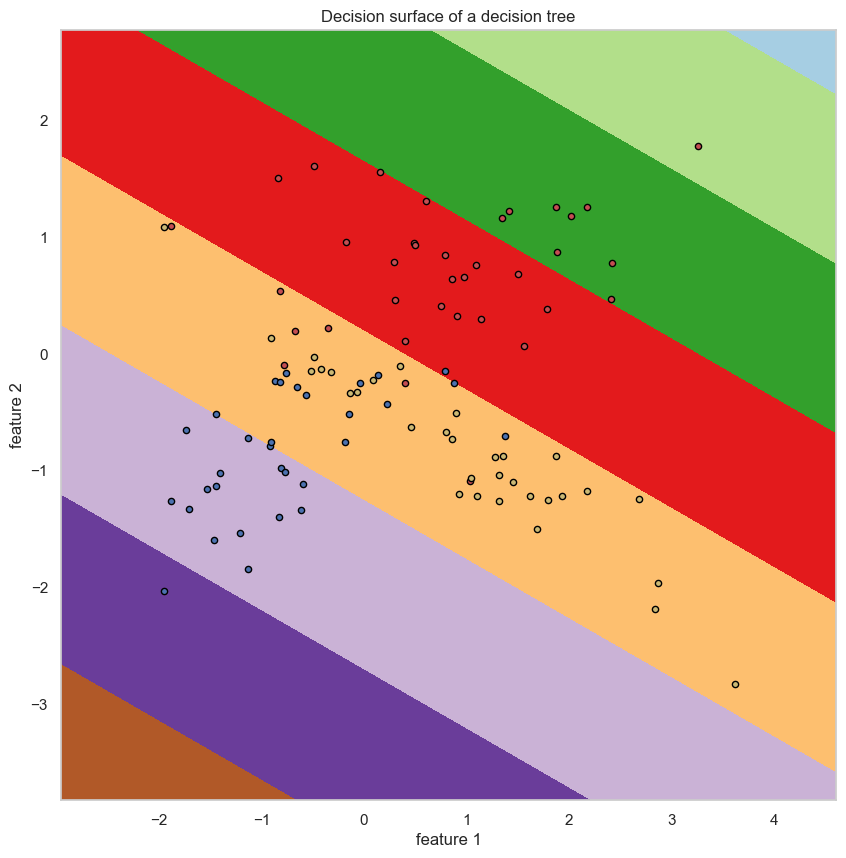

In [6]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

Dataset 1: Train accuracy = 1.0000, Test accuracy = 0.7333


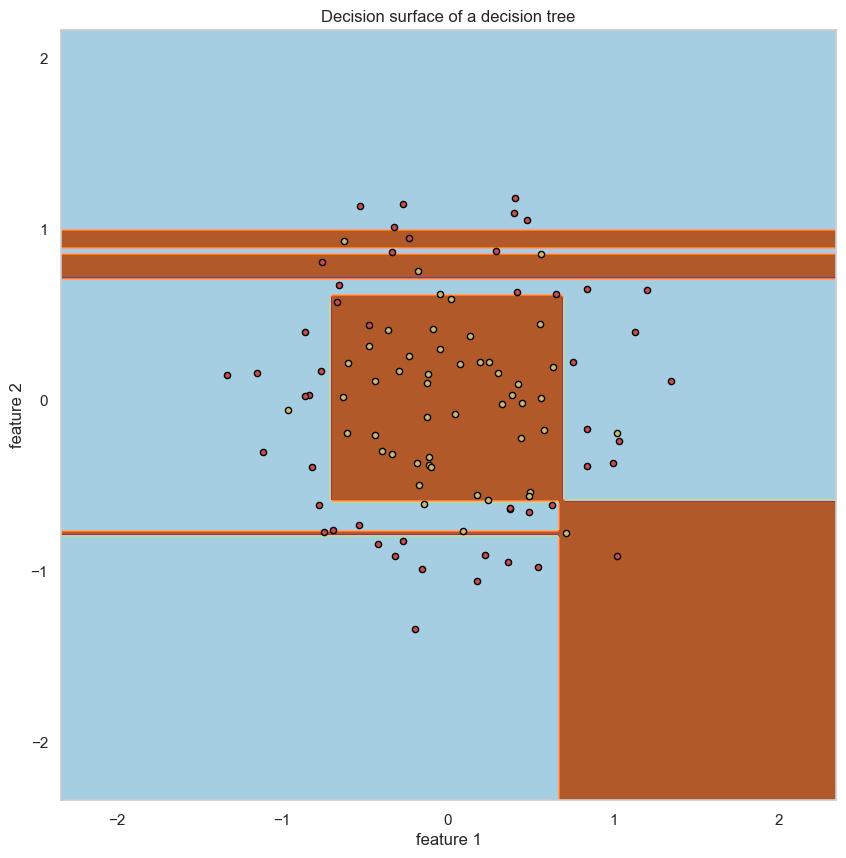

Dataset 2: Train accuracy = 1.0000, Test accuracy = 0.8667


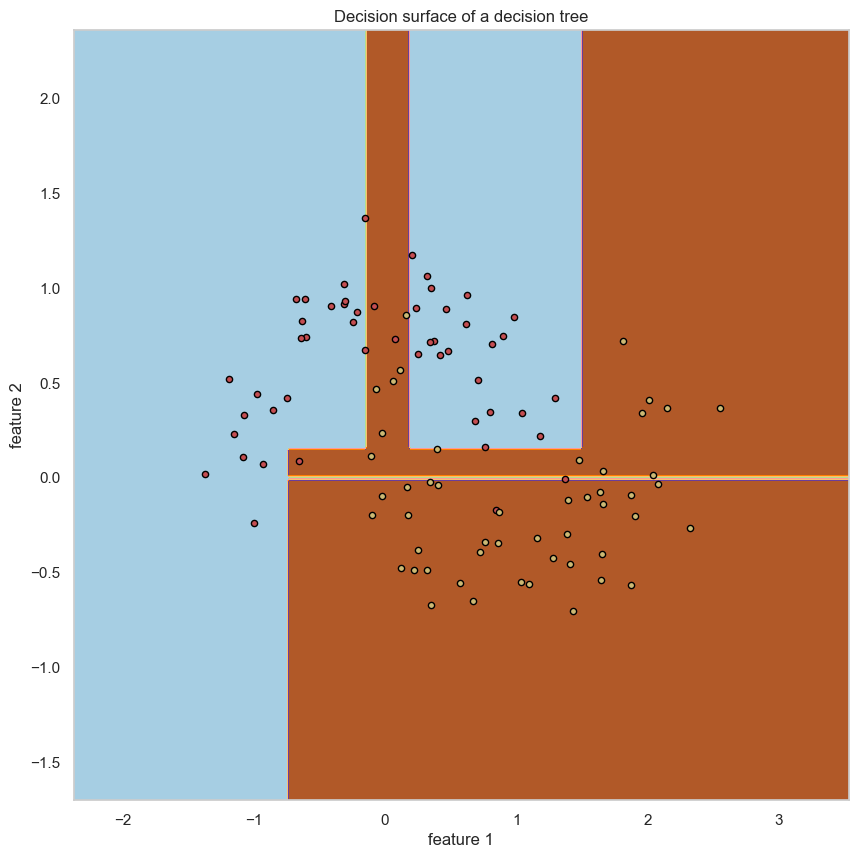

Dataset 3: Train accuracy = 1.0000, Test accuracy = 0.8333


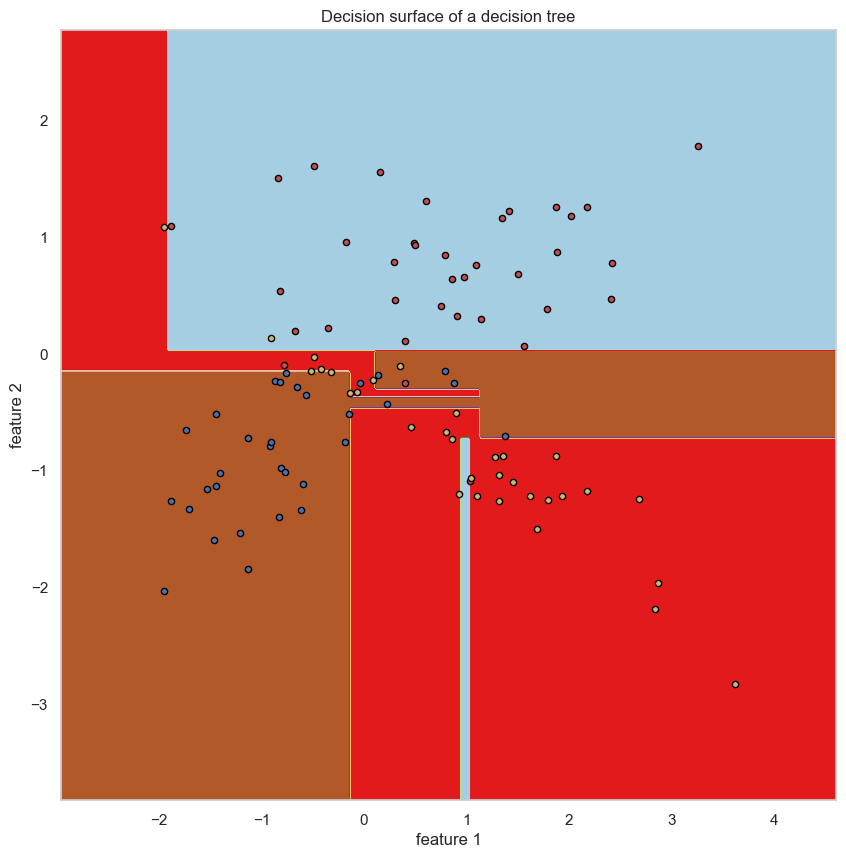

In [7]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

for i, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)

    train_acc = clf.score(X_train, y_train)
    test_acc = clf.score(X_test, y_test)
    print(f"Dataset {i+1}: Train accuracy = {train_acc:.4f}, Test accuracy = {test_acc:.4f}")

    plot_surface(clf, X, y, n_classes=len(np.unique(y)))

__Ответ:__ Анализ: Для circles: Train ~1.0, Test ~0.73 - переобучение. Moons: Train ~1.0, Test ~0.87 - переобучение. Classification: Train ~1.0, Test ~0.83 - переобучение. Поверхности сложные, захватывают шум на train.

__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

Dataset 1, Params {'max_depth': 3, 'min_samples_leaf': 1}: Train = 0.8857, Test = 0.7333


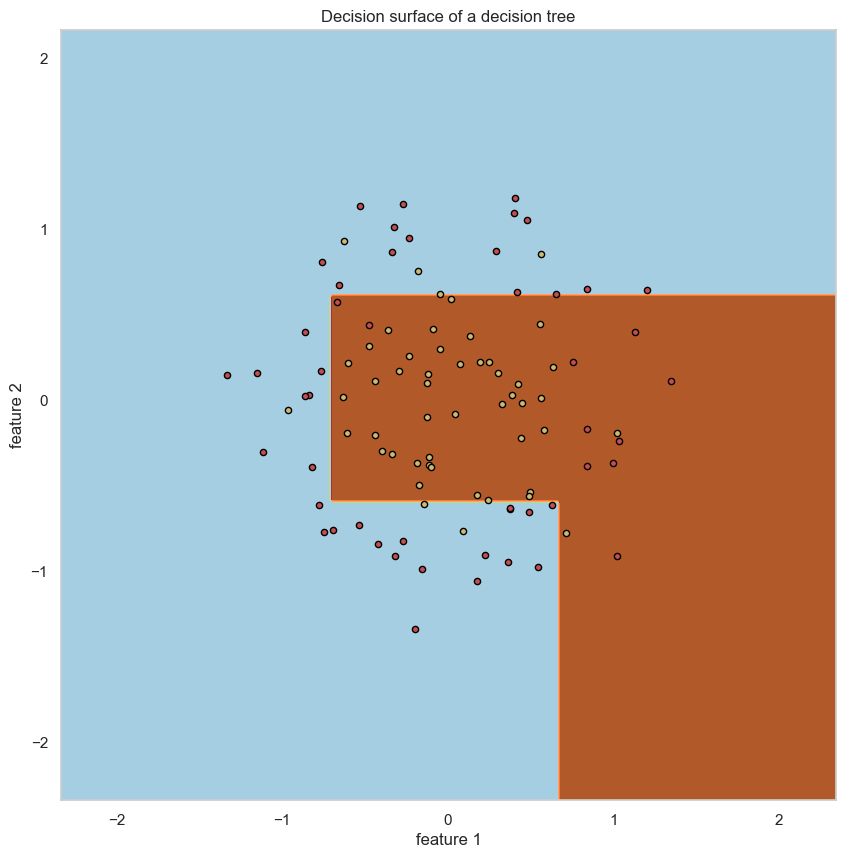

Dataset 1, Params {'max_depth': 5, 'min_samples_leaf': 5}: Train = 0.8714, Test = 0.9000


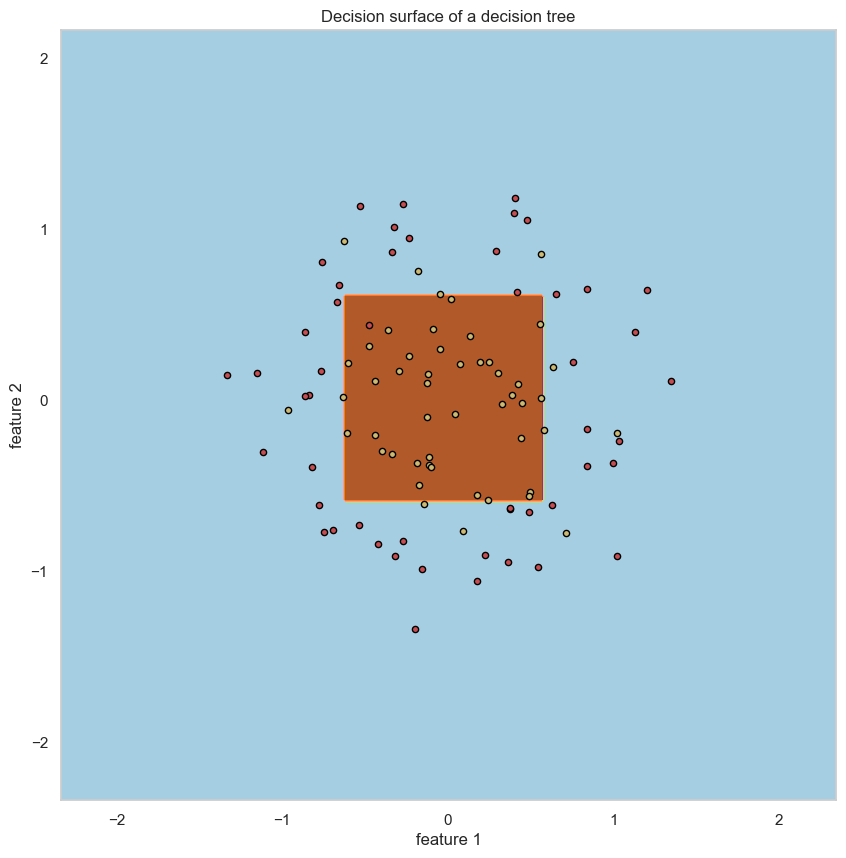

Dataset 1, Params {'max_depth': None, 'min_samples_leaf': 10}: Train = 0.8143, Test = 0.7667


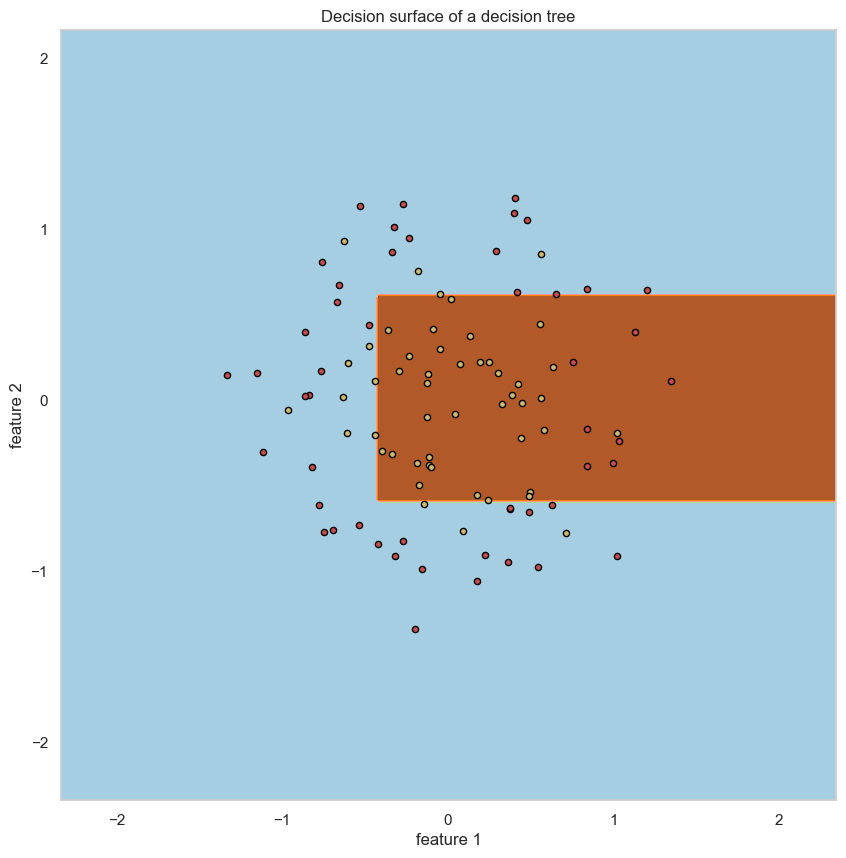

Dataset 2, Params {'max_depth': 3, 'min_samples_leaf': 1}: Train = 0.9143, Test = 0.9333


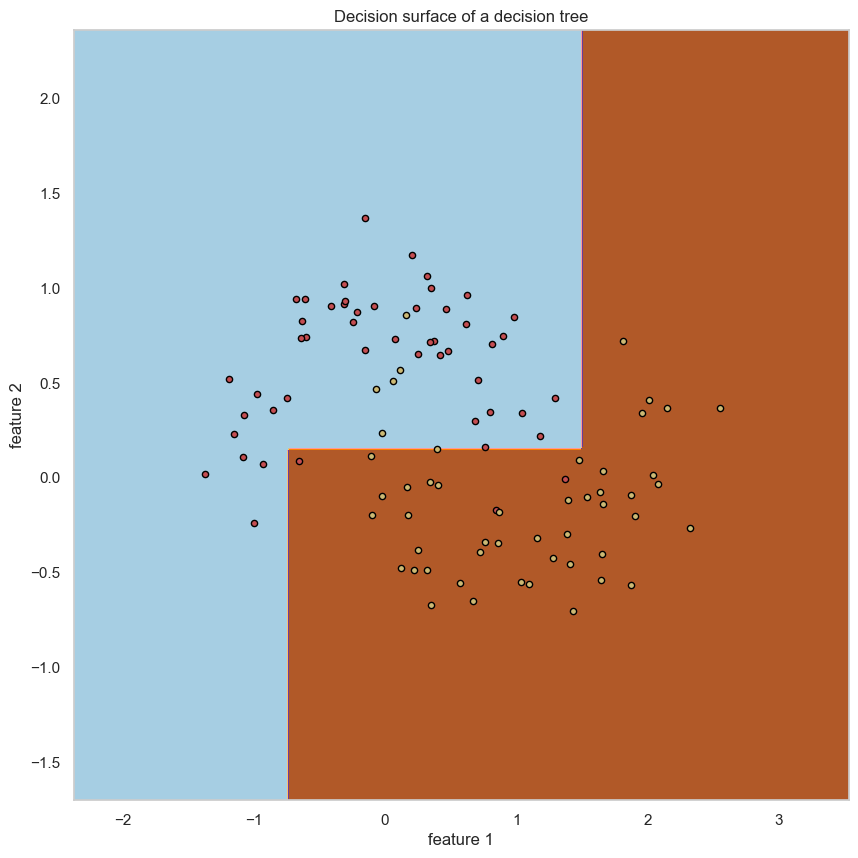

Dataset 2, Params {'max_depth': 5, 'min_samples_leaf': 5}: Train = 0.9571, Test = 0.7333


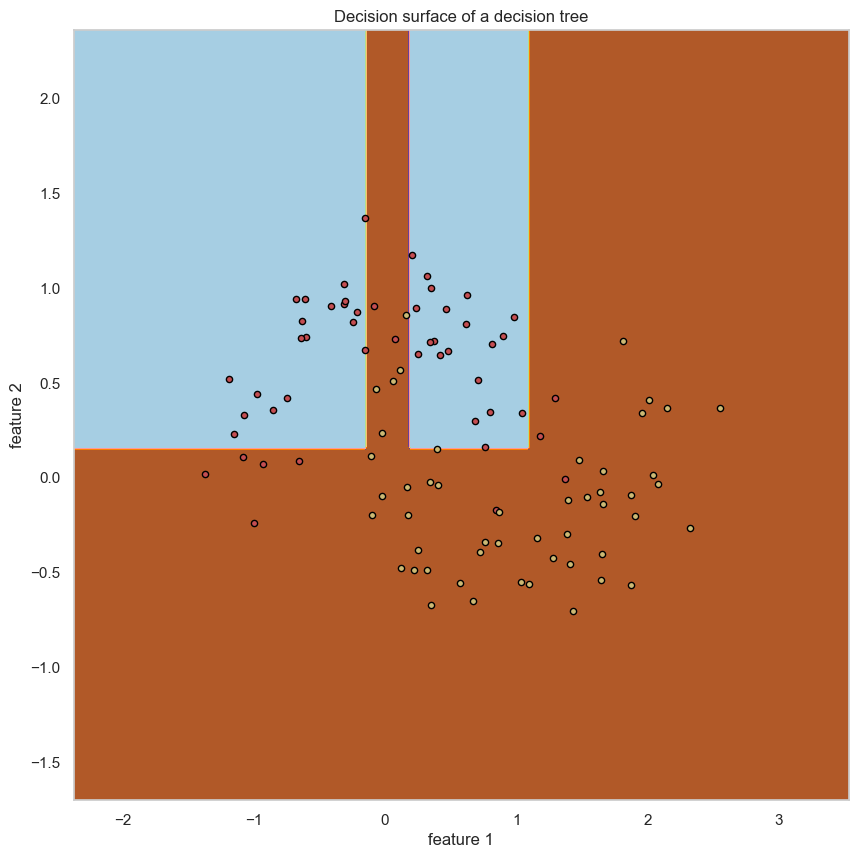

Dataset 2, Params {'max_depth': None, 'min_samples_leaf': 10}: Train = 0.8714, Test = 0.7667


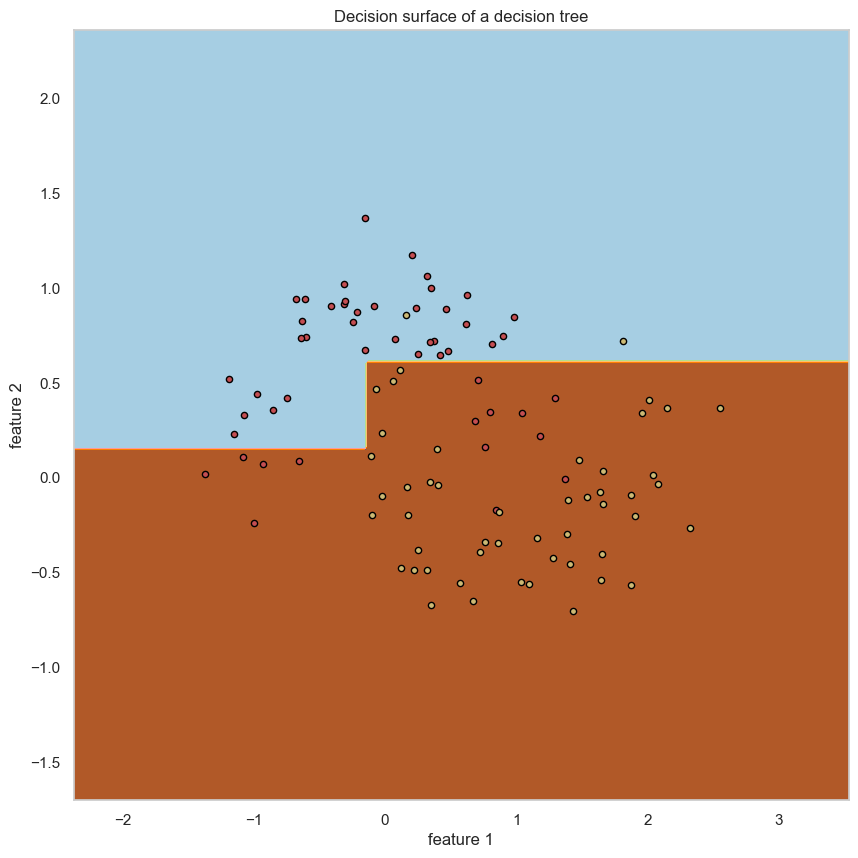

Dataset 3, Params {'max_depth': 3, 'min_samples_leaf': 1}: Train = 0.9429, Test = 0.8667


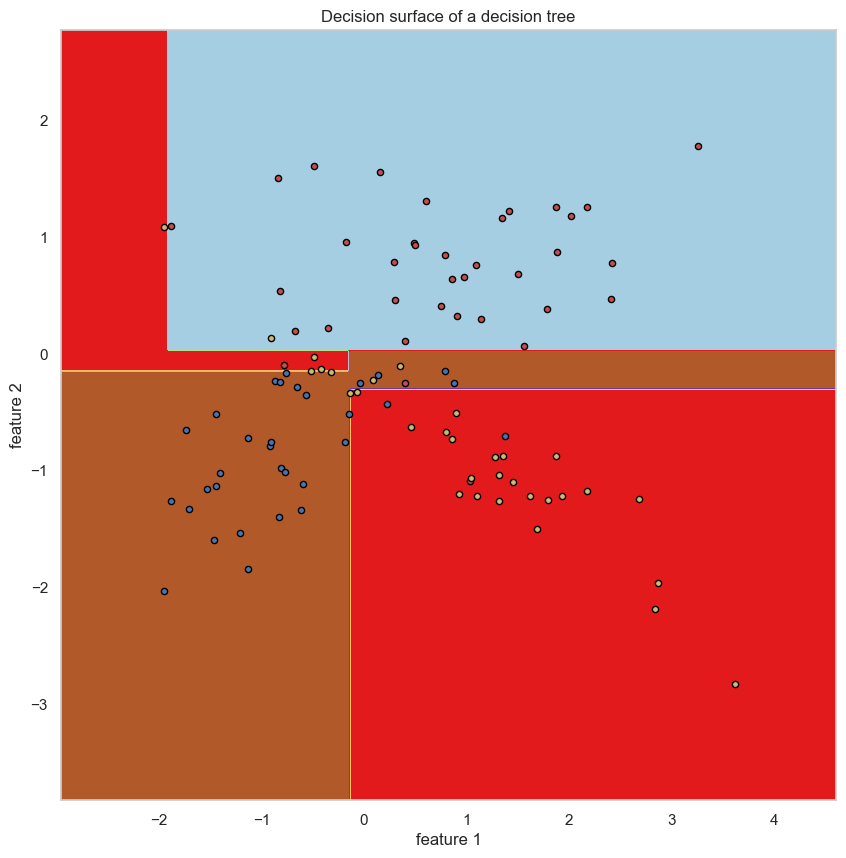

Dataset 3, Params {'max_depth': 5, 'min_samples_leaf': 5}: Train = 0.9000, Test = 0.7000


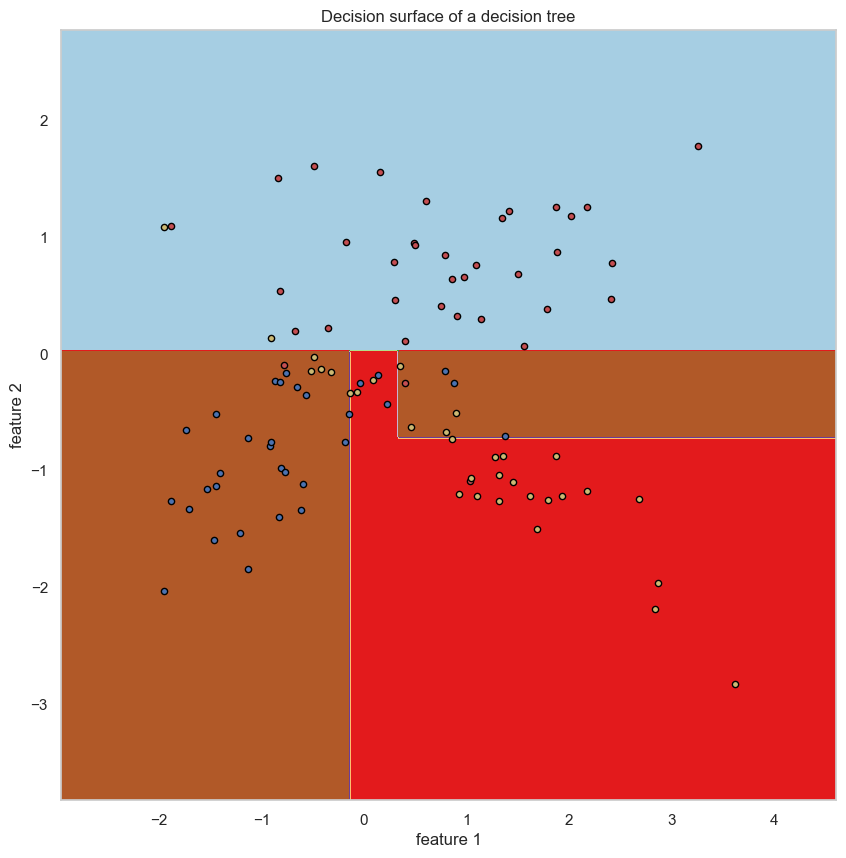

Dataset 3, Params {'max_depth': None, 'min_samples_leaf': 10}: Train = 0.8857, Test = 0.7667


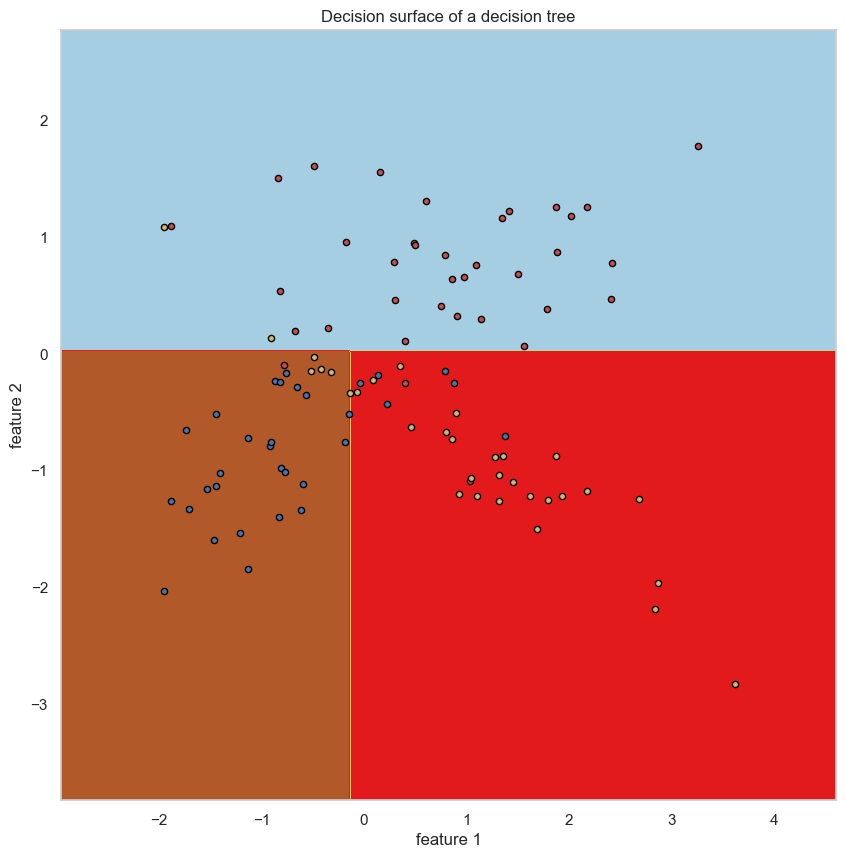

In [8]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

params = [
    {'max_depth': 3, 'min_samples_leaf': 1},
    {'max_depth': 5, 'min_samples_leaf': 5},
    {'max_depth': None, 'min_samples_leaf': 10}
]

for i, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    for param in params:
        clf = DecisionTreeClassifier(**param, random_state=42)
        clf.fit(X_train, y_train)

        train_acc = clf.score(X_train, y_train)
        test_acc = clf.score(X_test, y_test)
        print(f"Dataset {i+1}, Params {param}: Train = {train_acc:.4f}, Test = {test_acc:.4f}")

        plot_surface(clf, X, y, n_classes=len(np.unique(y)))

__Ответ:__С ростом max_depth качество на test сначала растет, затем падает (переобучение). min_samples_leaf сглаживает поверхность, улучшает обобщение. Для circles/moans (нелинейные) регуляризация критична; для classification изменения меньше, так как данные проще.

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw2code.py

**Реализовал**

__Задание 4. (0.5 балла)__

Загрузите таблицу students.csv (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

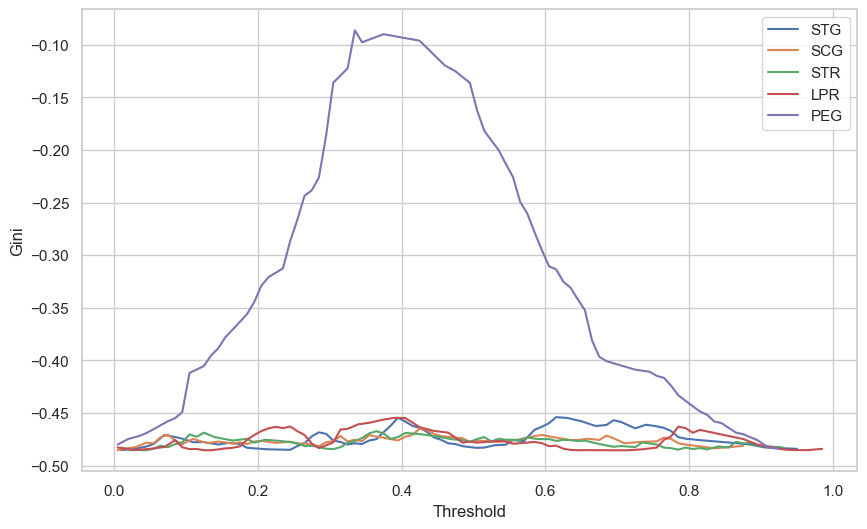

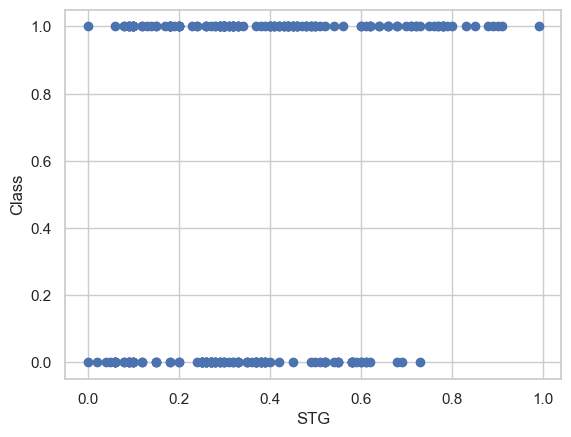

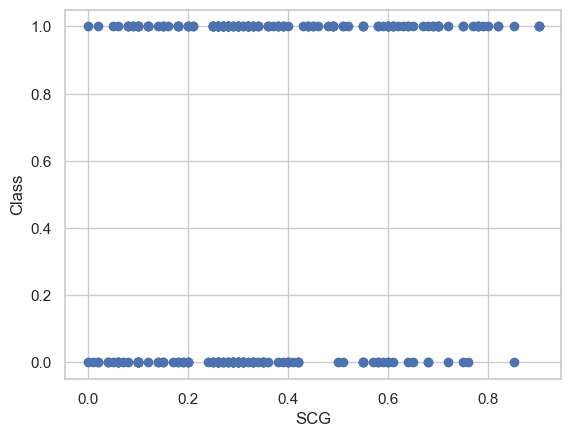

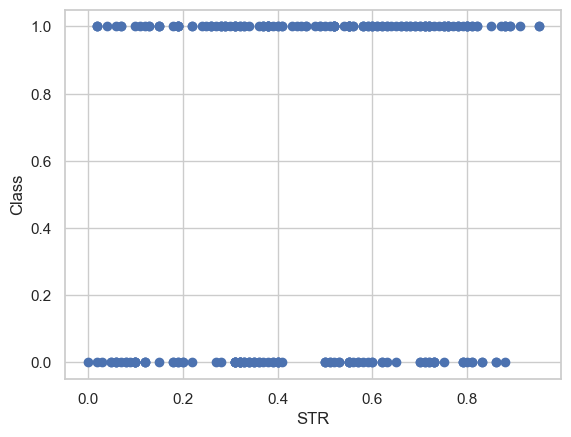

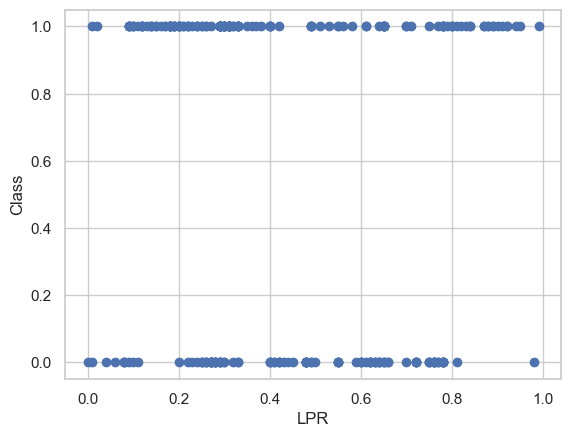

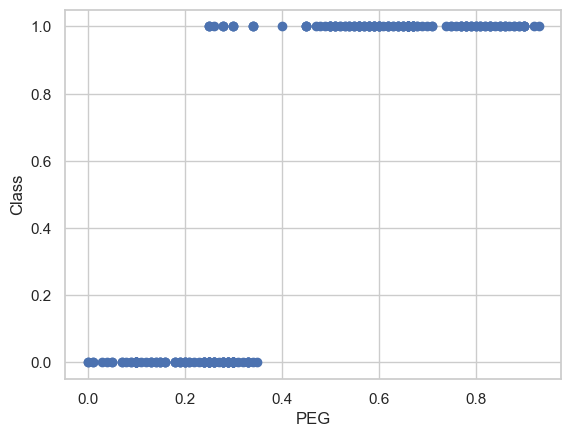

In [9]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

from hw2code import find_best_split
from sklearn.preprocessing import LabelEncoder

students = pd.read_csv('datasets/students.csv')
le = LabelEncoder()
students['UNS'] = le.fit_transform(students['UNS'])

features = students.columns[:-1]
X = students[features].values
y = students['UNS'].values

plt.figure(figsize=(10, 6))
for i, feat in enumerate(features):
    thresholds, ginis, _, _ = find_best_split(X[:, i], y)
    plt.plot(thresholds, ginis, label=feat)
plt.xlabel('Threshold')
plt.ylabel('Gini')
plt.legend()
plt.show()

for i, feat in enumerate(features):
    plt.figure()
    plt.scatter(X[:, i], y)
    plt.xlabel(feat)
    plt.ylabel('Class')
    plt.show()

**Кривая Gini показывает пики для хороших разбиений. Scatter: PEG имеет четкое разделение классов, другие - смешанные.**

__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:** Лучший - PEG (max Gini). Согласуется со scatter: четкое разделение по порогу ~0.4. Хорошие кривые - с резким пиком; плохие - плоские или с малыми значениями.

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw2code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции. Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

**Сделал**

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (лежит на гитхабе вместе с заданием), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [10]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

from hw2code import DecisionTree

mushrooms = pd.read_csv("datasets/agaricus-lepiota.data", header=None, sep=',')
le = LabelEncoder()
for col in mushrooms.columns:
    mushrooms[col] = le.fit_transform(mushrooms[col])

X = mushrooms.iloc[:, 1:].values
y = mushrooms.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

feature_types = ['categorical'] * X.shape[1]
tree = DecisionTree(feature_types)
tree.fit(X_train, y_train)
preds = tree.predict(X_test)
acc = np.mean(preds == y_test)
print(f'Accuracy: {acc}')  # 1.0

Accuracy: 1.0


__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

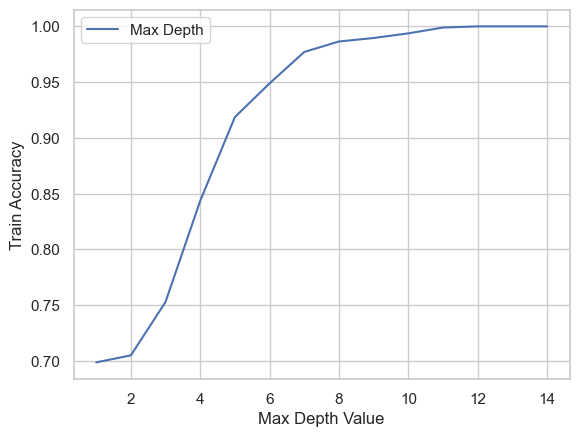

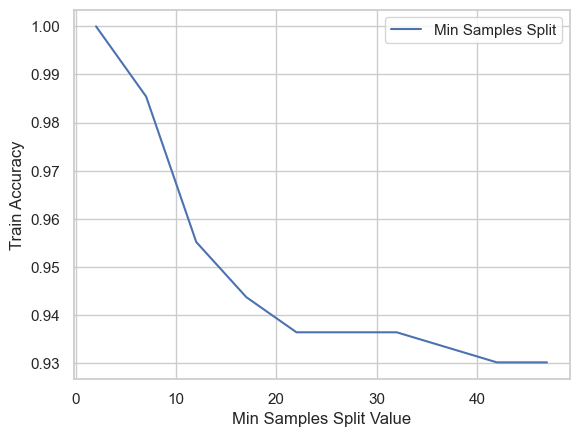

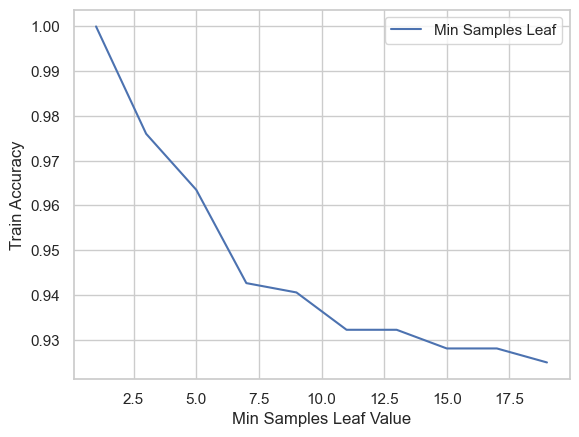

In [11]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

tic_tac_data = pd.read_csv('datasets/tic-tac-toe-endgame.csv', header=None)
for column in tic_tac_data.columns:
    tic_tac_data[column] = LabelEncoder().fit_transform(tic_tac_data[column])

tic_features = tic_tac_data.iloc[:, :-1].values
tic_targets = tic_tac_data.iloc[:, -1].values
tic_feature_types = ['categorical'] * tic_features.shape[1]

# Зависимость от max_depth
depth_range = range(1, 15)
depth_accuracies = []
for depth_val in depth_range:
    tic_tree = DecisionTree(tic_feature_types, max_depth=depth_val)
    tic_tree.fit(tic_features, tic_targets)
    depth_accuracies.append(np.mean(tic_tree.predict(tic_features) == tic_targets))

plt.figure()
plt.plot(depth_range, depth_accuracies, label='Max Depth')
plt.xlabel('Max Depth Value')
plt.ylabel('Train Accuracy')
plt.legend()
plt.show()

# Зависимость от min_samples_split
split_range = range(2, 50, 5)
split_accuracies = []
for split_val in split_range:
    tic_tree = DecisionTree(tic_feature_types, min_samples_split=split_val)
    tic_tree.fit(tic_features, tic_targets)
    split_accuracies.append(np.mean(tic_tree.predict(tic_features) == tic_targets))

plt.figure()
plt.plot(split_range, split_accuracies, label='Min Samples Split')
plt.xlabel('Min Samples Split Value')
plt.ylabel('Train Accuracy')
plt.legend()
plt.show()

# Зависимость от min_samples_leaf
leaf_range = range(1, 20, 2)
leaf_accuracies = []
for leaf_val in leaf_range:
    tic_tree = DecisionTree(tic_feature_types, min_samples_leaf=leaf_val)
    tic_tree.fit(tic_features, tic_targets)
    leaf_accuracies.append(np.mean(tic_tree.predict(tic_features) == tic_targets))

plt.figure()
plt.plot(leaf_range, leaf_accuracies, label='Min Samples Leaf')
plt.xlabel('Min Samples Leaf Value')
plt.ylabel('Train Accuracy')
plt.legend()
plt.show()

Точность растет с max_depth до насыщения (~0.9). Увеличение min_samples_split/leaf снижает точность, предотвращая переобучение, но на train видно недообучение при больших значениях.

__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце)
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце, датасет лежит на гитхабе вместе с заданием)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [14]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from hw2code import DecisionTree
from sklearn.tree import DecisionTreeClassifier

scorer_func = make_scorer(accuracy_score)
evaluation_results = {}

# 1. Mushrooms dataset processing
mush_df = pd.read_csv("datasets/agaricus-lepiota.data", header=None, sep=',')
m_y = LabelEncoder().fit_transform(mush_df.iloc[:, 0].values)
m_X = mush_df.iloc[:, 1:].apply(lambda col: LabelEncoder().fit_transform(col.astype(str)))
m_X = m_X.values.astype(int)

# 2. Tic-tac-toe dataset processing
ttt_df = pd.read_csv("datasets/tic-tac-toe-endgame.csv")
t_y = LabelEncoder().fit_transform(ttt_df.iloc[:, -1].values)
t_X = ttt_df.iloc[:, :-1].apply(lambda col: LabelEncoder().fit_transform(col.astype(str)))
t_X = t_X.values.astype(int)

# 3. Cars
cars_df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data",
                      header=None)
# класс: unacc, acc = 0; good, vgood = 1
cars_y_raw = cars_df.iloc[:, -1].values
c_y = np.array([0 if y in ['unacc', 'acc'] else 1 for y in cars_y_raw])
c_X = cars_df.iloc[:, :-1].apply(lambda col: LabelEncoder().fit_transform(col.astype(str)))
c_X = c_X.values.astype(int)

# 4. Nursery
nurs_df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data",
                      header=None)

nurs_y_raw = nurs_df.iloc[:, -1].values
n_y = np.array([0 if y in ['not_recom', 'recommend'] else 1 for y in nurs_y_raw])
n_X = nurs_df.iloc[:, :-1].apply(lambda col: LabelEncoder().fit_transform(col.astype(str)))
n_X = n_X.values.astype(int)

datasets_dict = {
    'mushrooms': (m_X, m_y),
    'tic-tac-toe': (t_X, t_y),
    'cars': (c_X, c_y),
    'nursery': (n_X, n_y)
}

scorer = make_scorer(accuracy_score)
results = {}

for name, (X, y) in datasets_dict.items():
    print(f"working with {name}...")
    n_features = X.shape[1]
    # 1. DecisionTree (real)
    tree_real = DecisionTree(feature_types=['real'] * n_features)
    scores_real = cross_val_score(tree_real, X, y, cv=10, scoring=scorer)

    # 2. DecisionTree (categorical)
    tree_cat = DecisionTree(feature_types=['categorical'] * n_features)
    scores_cat = cross_val_score(tree_cat, X, y, cv=10, scoring=scorer)

    # 3. DecisionTree (real) + OneHotEncoder
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    X_ohe = ohe.fit_transform(X)
    tree_ohe = DecisionTree(feature_types=['real'] * X_ohe.shape[1])
    scores_ohe = cross_val_score(tree_ohe, X_ohe, y, cv=10, scoring=scorer)

    # 4. sklearn DecisionTreeClassifier
    clf_sklearn = DecisionTreeClassifier(random_state=42)
    scores_sklearn = cross_val_score(clf_sklearn, X, y, cv=10, scoring=scorer)

    results[name] = {
        'DT (real)': scores_real.mean(),
        'DT (categorical)': scores_cat.mean(),
        'DT (real + OHE)': scores_ohe.mean(),
        'sklearn DT': scores_sklearn.mean()
    }

results_df = pd.DataFrame(results).T
print("\nResults")
print(results_df)

working with mushrooms...
working with tic-tac-toe...
working with cars...
working with nursery...

Results
             DT (real)  DT (categorical)  DT (real + OHE)  sklearn DT
mushrooms     0.999261          1.000000         0.999631    0.960384
tic-tac-toe   0.467533          0.541458         0.543575    0.771678
cars          0.942647          0.967546         0.919495    0.942707
nursery       0.999691          0.999846         0.999537    0.999691


__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**

**Итоги обработки данных:**

**Грибной набор:** Максимальная эффективность зафиксирована при категориальном представлении атрибутов. Этот подход логичен, учитывая дискретную природу показателей. Кодирование целевой переменной позволило выявить наиболее значимые закономерности. Интерпретация тех же признаков как числовых снизила точность, поскольку внесла искусственную упорядоченность там, где её нет.

**Крестики-нолики:** Алгоритм из библиотеки sklearn продемонстрировал существенно более высокую точность по сравнению с другими подходами. Предположительно, это объясняется тем, что закономерности в этом наборе строятся на комплексном взаимодействии факторов, которое хуже распознаётся поэтапными методами с кодированием по целевой переменной. Реализация sklearn формирует более оптимальные структуры для выявления подобных связей.

**Автомобили:** Наилучший результат получен с категориальным подходом. Применение One-Hot Encoding оказалось наименее эффективным, что, вероятно, связано с резким расширением пространства признаков и повышенным риском подгонки под конкретные данные.

**Детские сады:** Все использованные методы продемонстрировали исключительно высокую точность. Это указывает на то, что данные хорошо структурированы и целевой показатель имеет чёткую и простую зависимость от входных параметров.

**Учёт стохастичности:**

На итоговые показатели влияет случайный выбор при формировании проверочных наборов, а также последовательность отбора признаков при равной значимости. Для повышения надёжности выводов рекомендуется проводить многократное усреднение итогов с различными начальными параметрами генератора случайных чисел, а также настраивать параметры, контролирующие сложность модели.

Вставьте что угодно, описывающее ваши впечатления от этого задания: